In [1]:
import torch
from torch import optim, nn
import numpy as np

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

from UNet import ssim_loss
from models.vqvae import VQVAE

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([5, 386, 3, 64, 64])

torch.Size([4, 3, 72, 72])


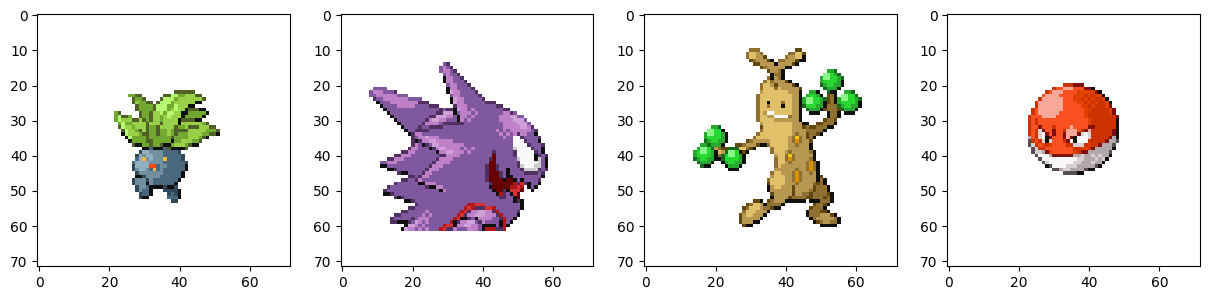

In [2]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)
sobel = Sobel()

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #v2.RandomApply([v2.RandomAffine(0, (0, 0), (0.8, 1.4), 0, fill=1.0)], .2),
    #v2.RandomApply([v2.RandomRotation(360, fill=1.0)], .2),
    #Sobel(),
])
#col_transform = v2.Compose([
#    v2.RandomApply([v2.ColorJitter()], .3),
#    v2.RandomApply([v2.RandomChannelPermutation()], .3),
#    v2.RandomGrayscale(p = .3),
#])

bs = 4
source = torch.randint(0, 5, (bs,))
batch = torch.randperm(385)[:bs]
x0 = pimages[source, batch]
#x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
x0 = torch.stack([pos_transform(x) for x in x0], dim=0)
print(x0.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [3]:
#https://www.researchgate.net/figure/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the_fig2_348947034
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mha = nn.MultiheadAttention(emb_dim, num_heads=2, batch_first=True) ##2?

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            #nn.Dropout(0.1),
        )

    def forward(self, x):
        x_ln = self.ln1(x)
        att, _ = self.mha(x_ln, x_ln, x_ln)
        
        att = self.ln2(att + x)
        return self.mlp(att) + att

In [4]:
#https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585
class MyMAE(nn.Module):
    def __init__(self, img_size, patch_size, emb_dim):
        super().__init__()
        assert img_size % patch_size == 0

        self.emb_dim = emb_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // self.patch_size) ** 2
        self.masked_size = int(0.75 * self.num_patches)

        self.patch_embedding = nn.Conv2d(3, emb_dim, 
                                         kernel_size=patch_size, 
                                         stride=patch_size,
                                         bias=False) #pos embedding?

        self.pos_embedding = nn.Parameter(torch.zeros(self.num_patches, emb_dim), requires_grad=False)
        
        self.encoder = nn.Sequential(*[Transformer(emb_dim) for i in range(8)])
        self.decoder = nn.Sequential(*[Transformer(emb_dim) for i in range(2)])

        self.decoder_emb_dim = self.emb_dim
        self.decoder_emb = nn.Linear(self.emb_dim, self.decoder_emb_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder_emb_dim))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.decoder_pos_emb = nn.Parameter(torch.zeros(self.num_patches, self.decoder_emb_dim))

        self.img_recov = nn.Linear(self.decoder_emb_dim, 3 * (self.patch_size ** 2))
        

    def forward(self, x):
        bs, _, _, _ = x.shape
        device = x.device

        patches = self.patch_embedding(x)
        patches = patches.flatten(2, 3).transpose(1, 2)

        mask = torch.randperm(self.num_patches, device=device) #img size independent?
        mask = mask[:-self.masked_size]
        masked = patches[:, mask, :]

        pos_emb = self.pos_embedding[mask, :]
        tokens = masked + pos_emb[None, ...]        
        features = self.encoder(tokens)

        ###### bottleneck

        tokens = self.mask_token.repeat(bs, self.num_patches, 1)
        tokens[:, mask, :] = self.decoder_emb(features)

        tokens = tokens + self.decoder_pos_emb
        features = self.decoder(tokens)

        image = self.img_recov(features)

        image = image.transpose(1,2)
        image = nn.functional.fold(image, 
                                   kernel_size=self.patch_size, 
                                   output_size=self.img_size, 
                                   stride=self.patch_size)
        
        return image

  0%|          | 0/250000 [00:00<?, ?it/s]

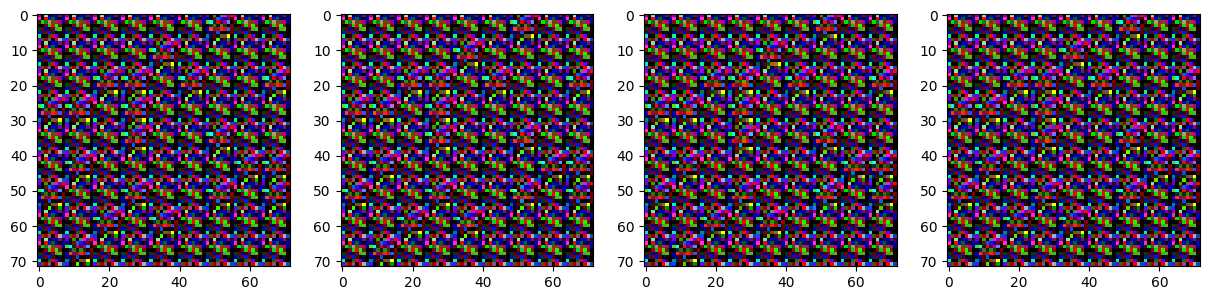

  1%|          | 1995/250000 [00:20<41:54, 98.64it/s] 

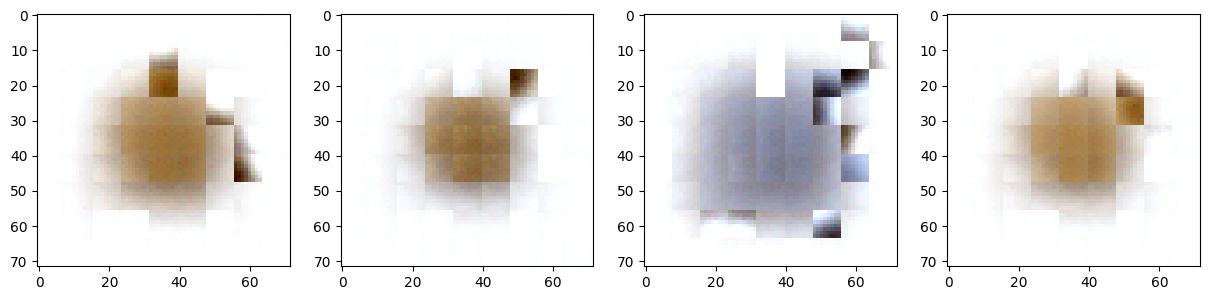

  2%|▏         | 4000/250000 [00:40<41:46, 98.13it/s]  

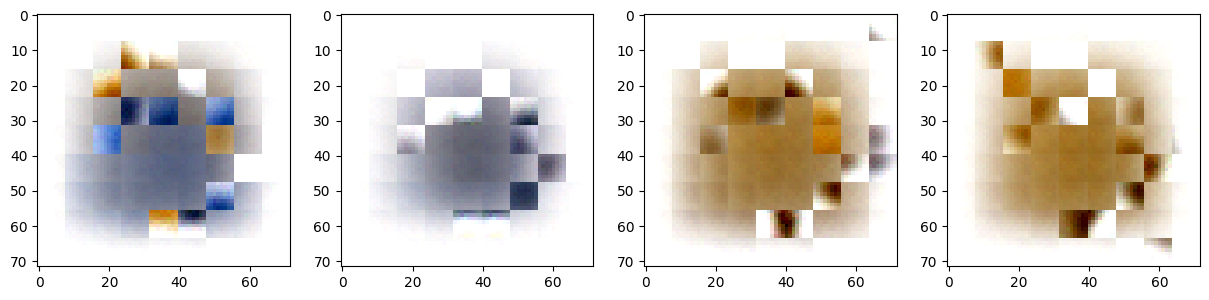

  2%|▏         | 5997/250000 [01:00<40:22, 100.73it/s] 

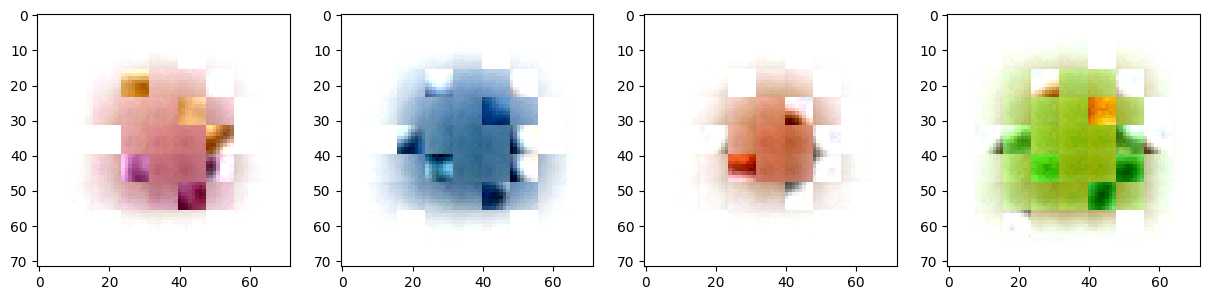

  3%|▎         | 7995/250000 [01:20<40:03, 100.71it/s] 

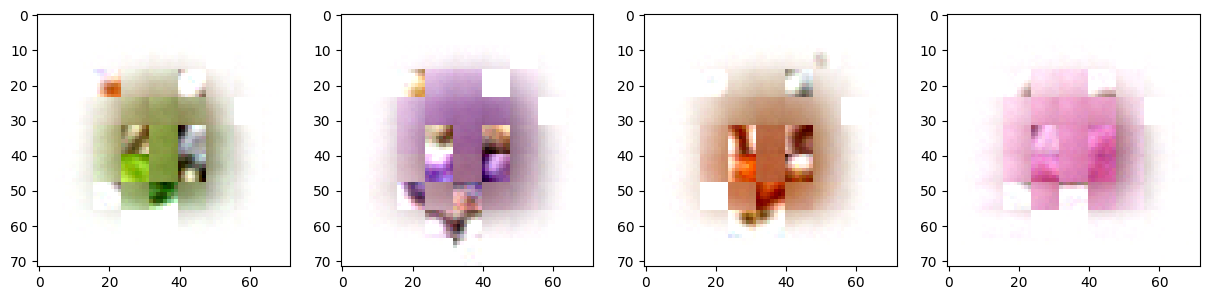

  4%|▍         | 9996/250000 [01:40<38:51, 102.95it/s] 

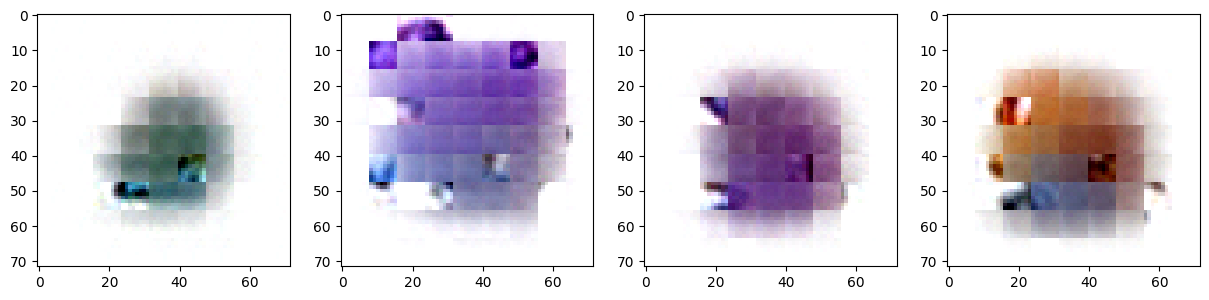

  5%|▍         | 11994/250000 [02:00<38:34, 102.82it/s]

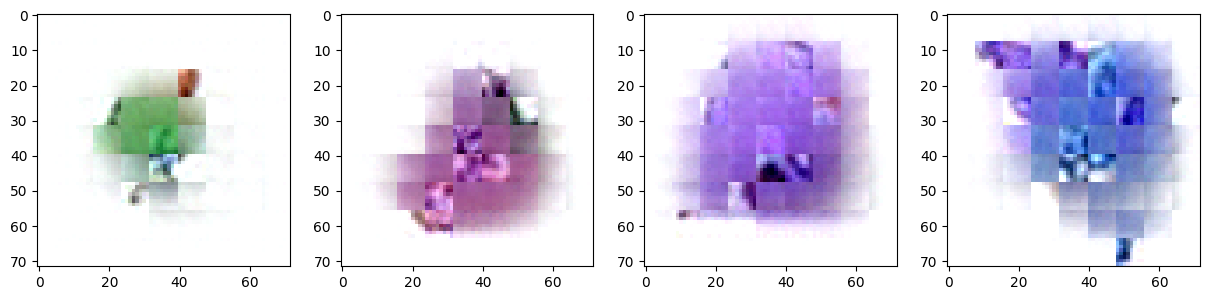

  6%|▌         | 13996/250000 [02:21<38:50, 101.29it/s]

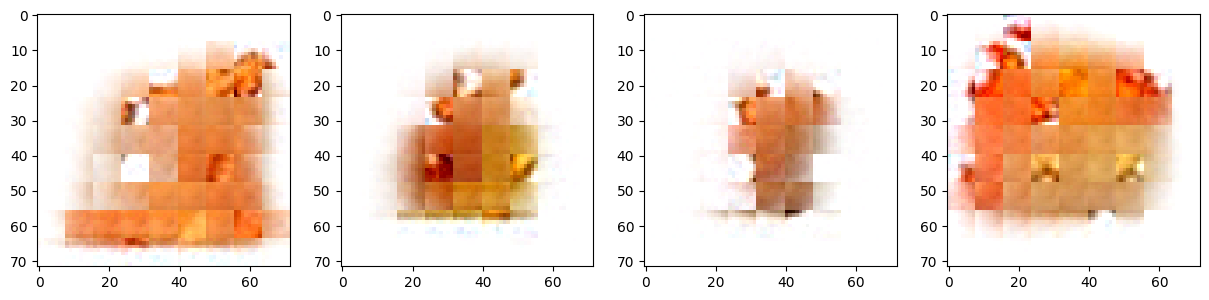

  6%|▋         | 15991/250000 [02:41<39:51, 97.86it/s] 

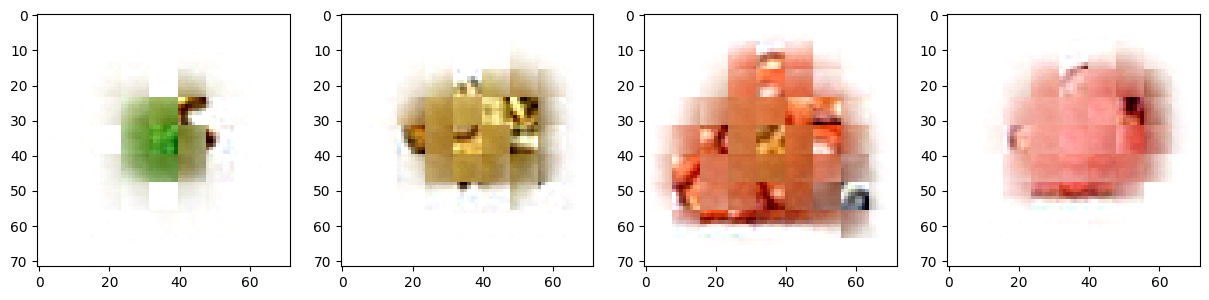

  7%|▋         | 17994/250000 [03:01<40:03, 96.53it/s] 

  8%|▊         | 19995/250000 [03:21<41:06, 93.26it/s] 

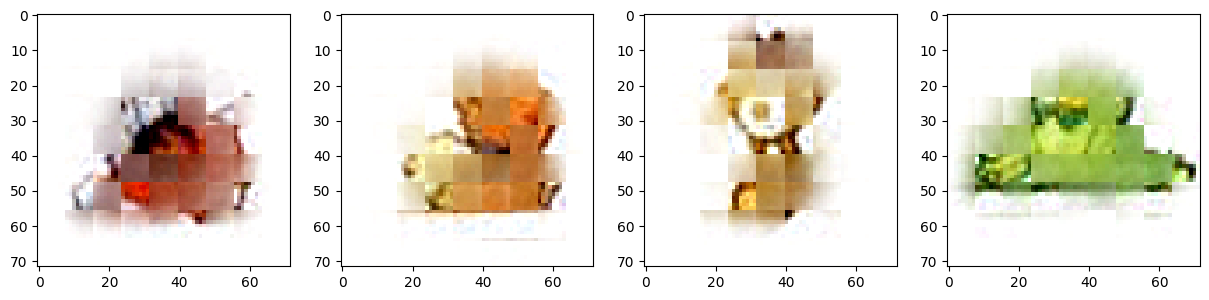

  9%|▉         | 22000/250000 [03:41<38:29, 98.72it/s]  

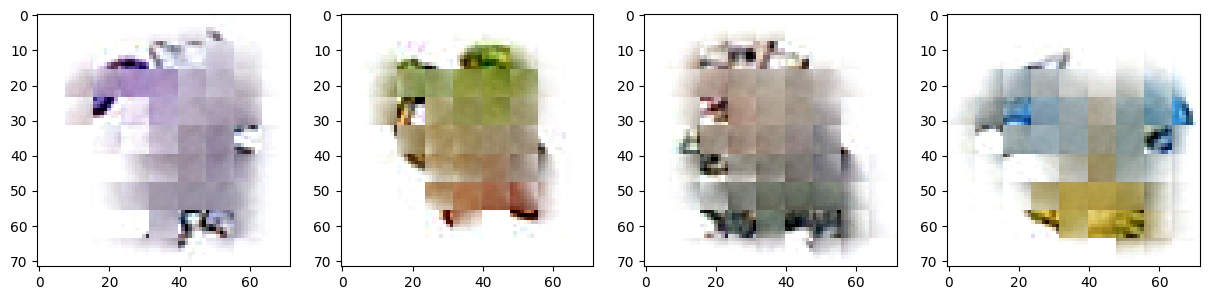

 10%|▉         | 23999/250000 [04:02<37:39, 100.04it/s]

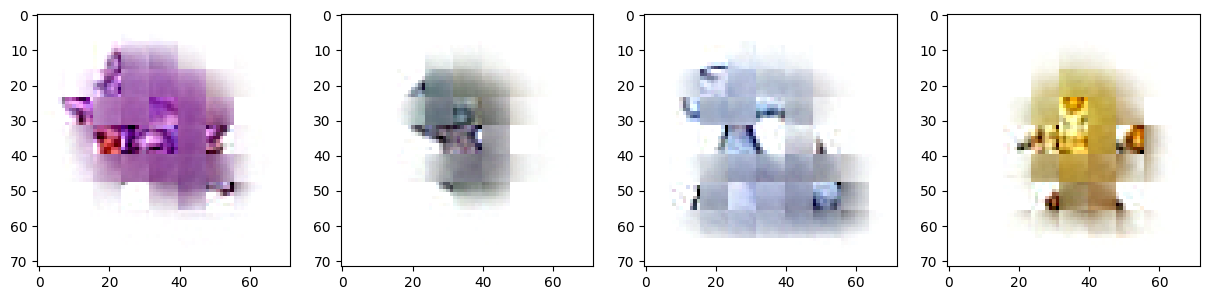

 10%|█         | 25996/250000 [04:22<37:08, 100.50it/s] 

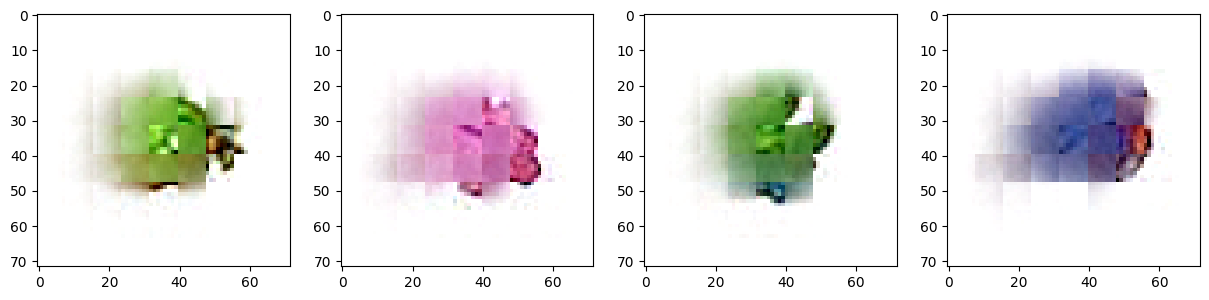

 11%|█         | 27996/250000 [04:43<36:11, 102.25it/s]

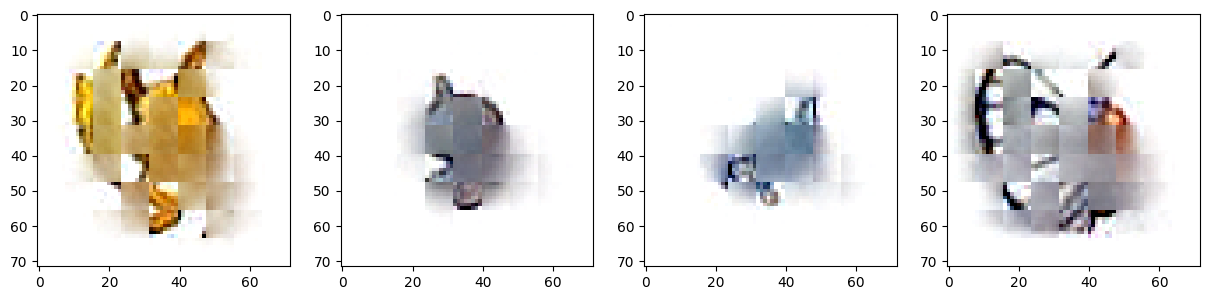

 12%|█▏        | 29994/250000 [05:03<35:36, 102.96it/s]

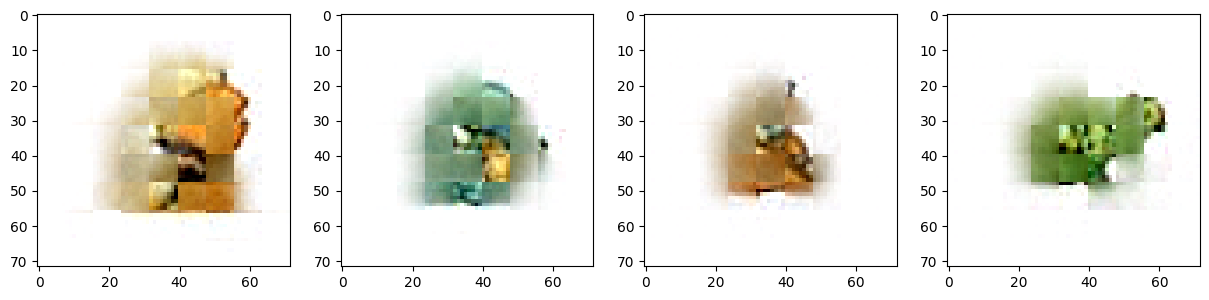

 13%|█▎        | 31998/250000 [05:23<35:00, 103.80it/s]

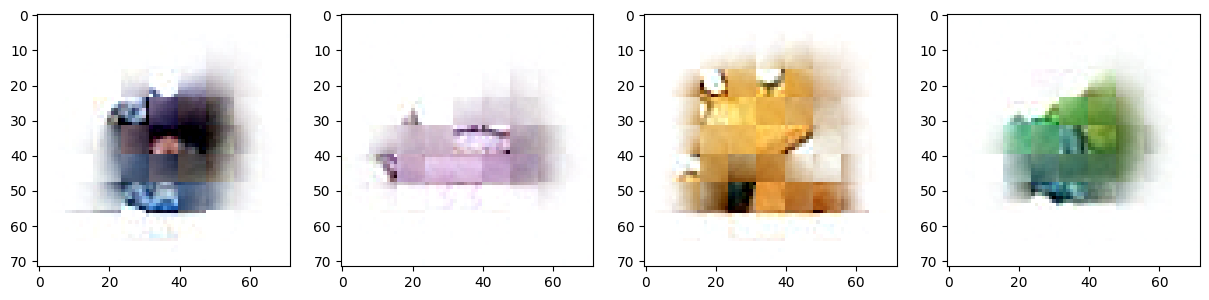

 14%|█▎        | 33997/250000 [05:43<37:18, 96.51it/s] 

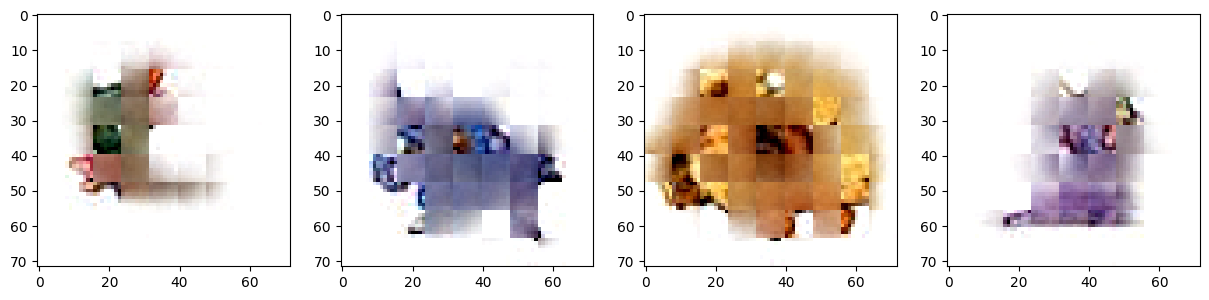

 14%|█▍        | 36000/250000 [06:04<34:07, 104.50it/s]

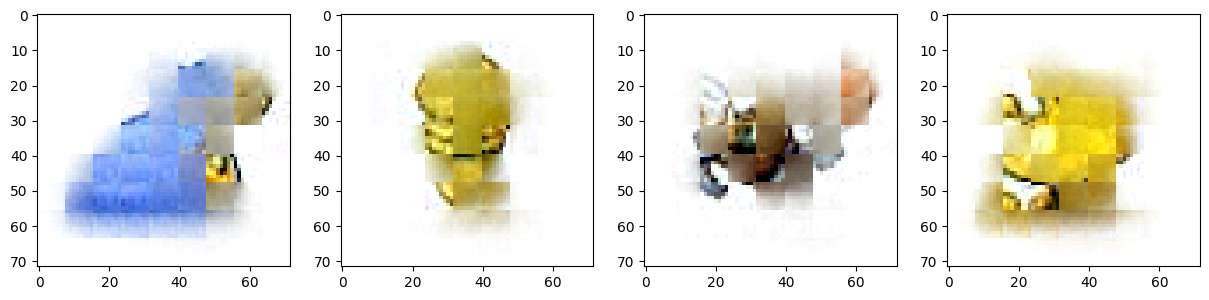

 15%|█▌        | 37990/250000 [06:24<34:50, 101.43it/s]

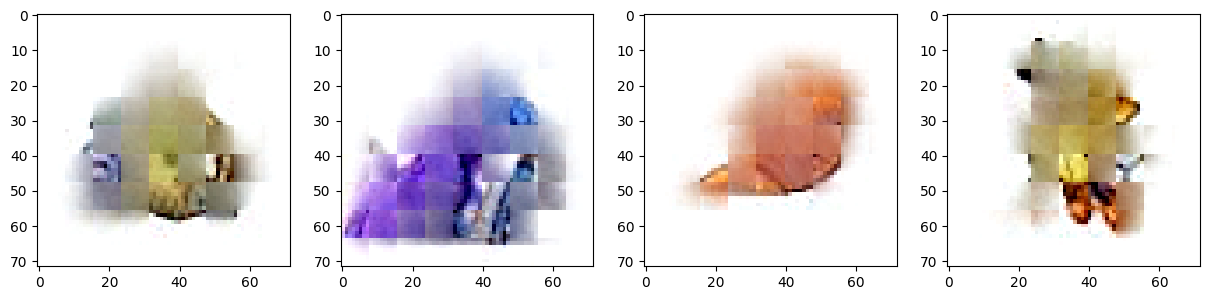

 16%|█▌        | 39990/250000 [06:44<34:24, 101.72it/s] 

 17%|█▋        | 41993/250000 [07:04<34:45, 99.75it/s] 

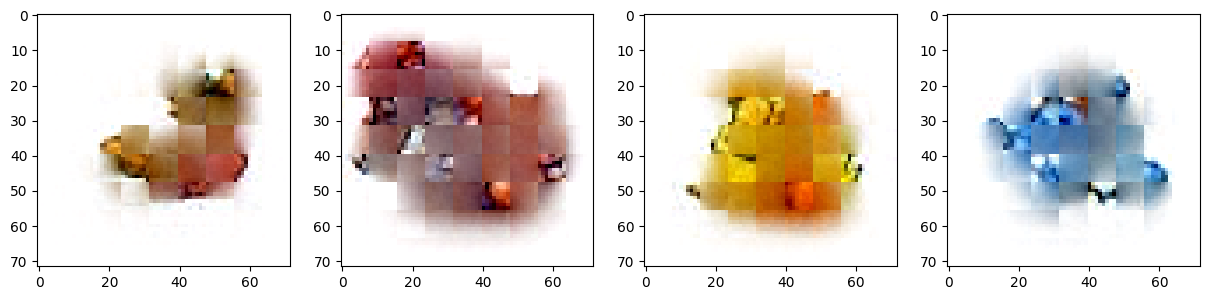

 18%|█▊        | 43992/250000 [07:24<34:46, 98.75it/s] 

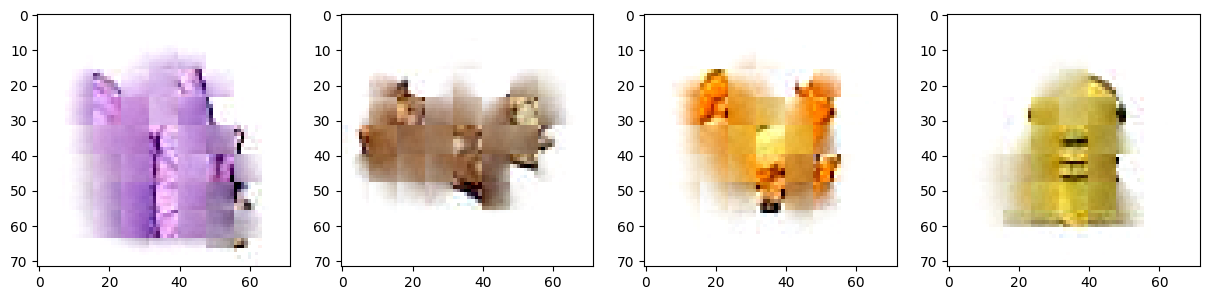

 18%|█▊        | 45996/250000 [07:45<34:10, 99.49it/s] 

 19%|█▉        | 47995/250000 [08:05<33:52, 99.41it/s] 

 20%|█▉        | 49994/250000 [08:25<33:11, 100.45it/s]

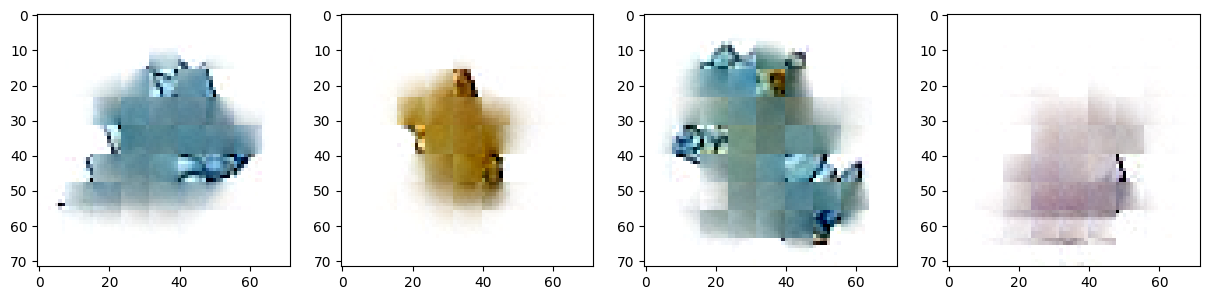

 21%|██        | 51998/250000 [08:45<32:25, 101.76it/s]

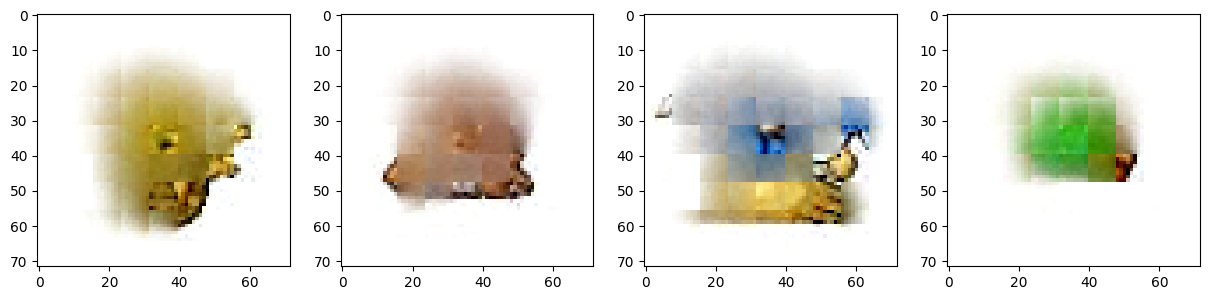

 22%|██▏       | 53998/250000 [09:05<32:35, 100.24it/s]

 22%|██▏       | 55991/250000 [09:25<32:18, 100.06it/s]

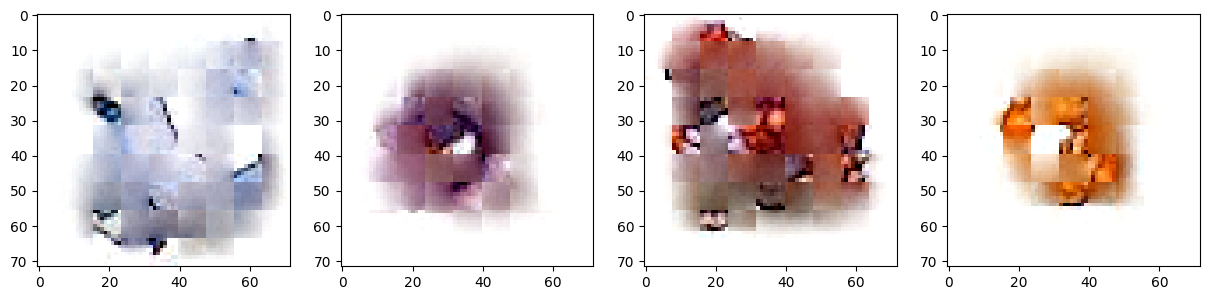

 23%|██▎       | 57999/250000 [09:45<31:49, 100.53it/s]

 24%|██▍       | 59996/250000 [10:06<31:05, 101.86it/s]

 25%|██▍       | 61991/250000 [10:26<31:31, 99.40it/s] 

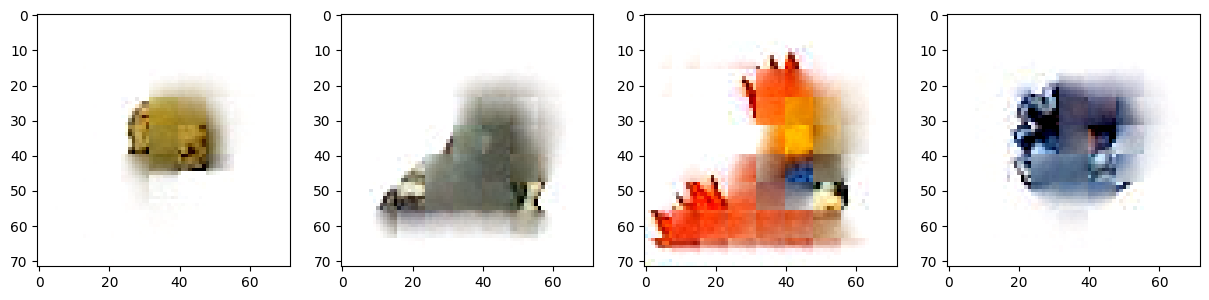

 26%|██▌       | 63991/250000 [10:46<31:23, 98.76it/s] 

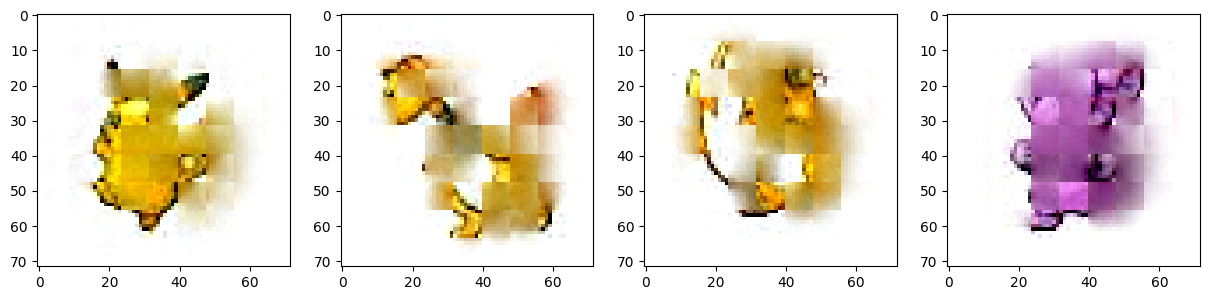

 26%|██▋       | 65996/250000 [11:06<30:26, 100.73it/s]

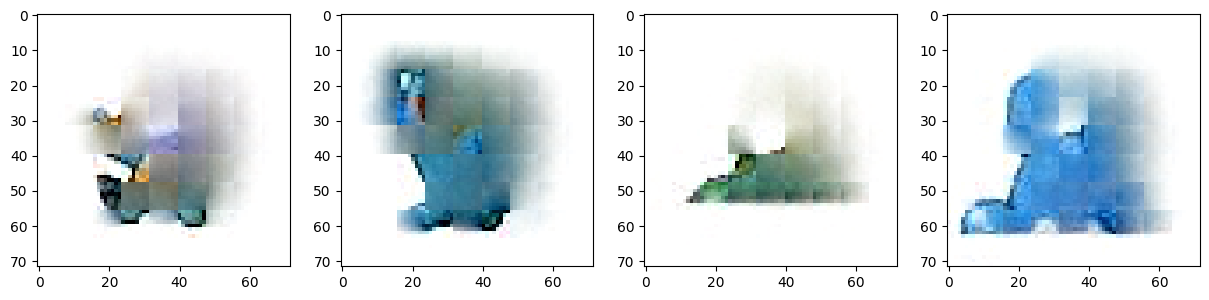

 27%|██▋       | 67990/250000 [11:26<29:40, 102.20it/s]

 28%|██▊       | 70000/250000 [11:47<29:42, 100.98it/s]

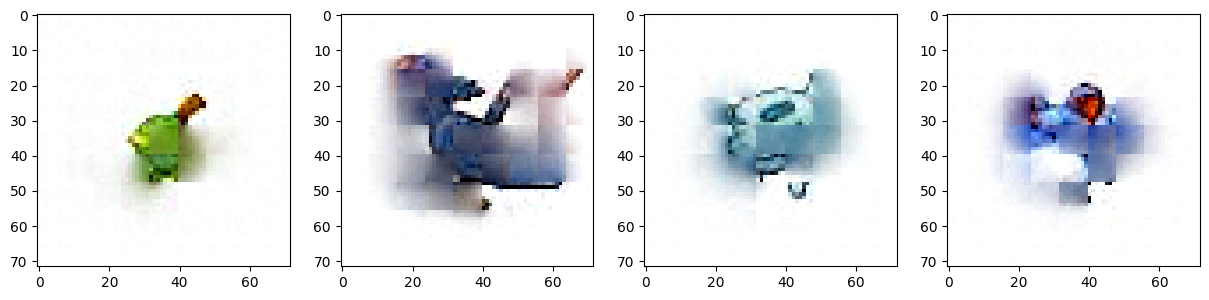

 29%|██▉       | 71991/250000 [12:07<29:49, 99.46it/s] 

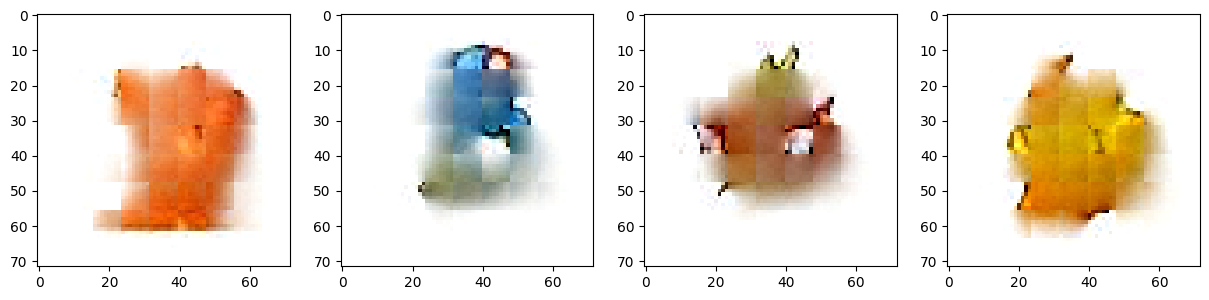

 30%|██▉       | 73993/250000 [12:27<29:32, 99.27it/s] 

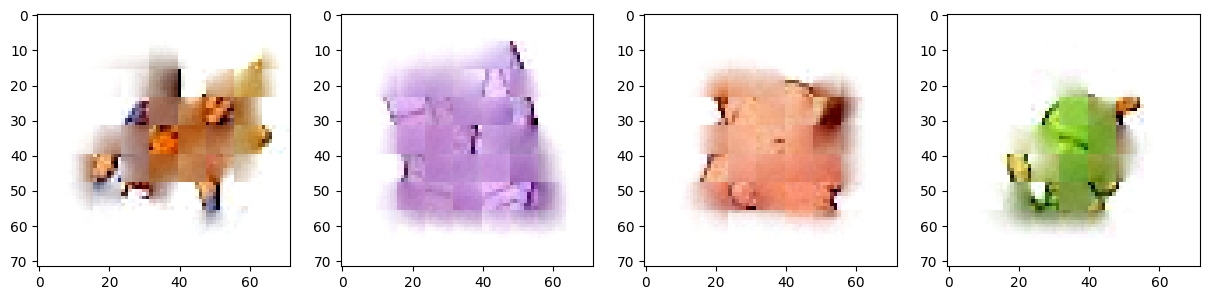

 30%|███       | 76000/250000 [12:48<28:57, 100.12it/s]

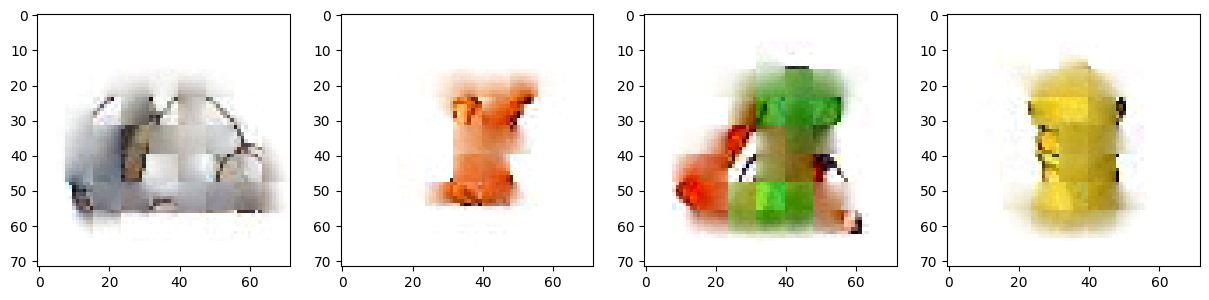

 31%|███       | 77991/250000 [13:08<28:24, 100.91it/s]

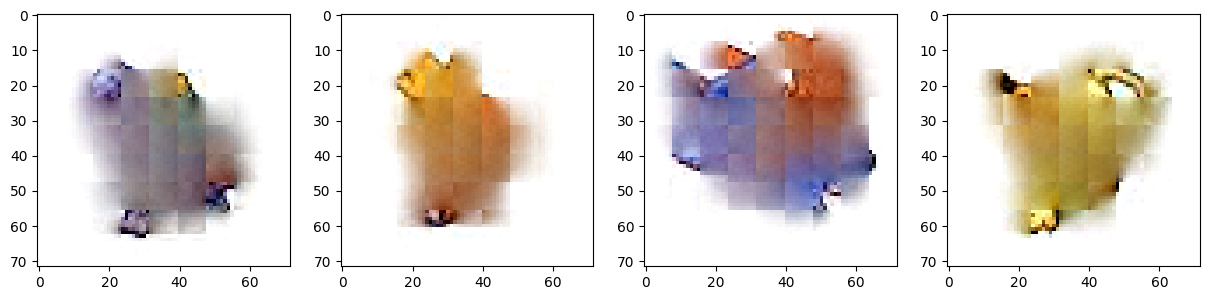

 32%|███▏      | 79998/250000 [13:28<28:26, 99.64it/s] 

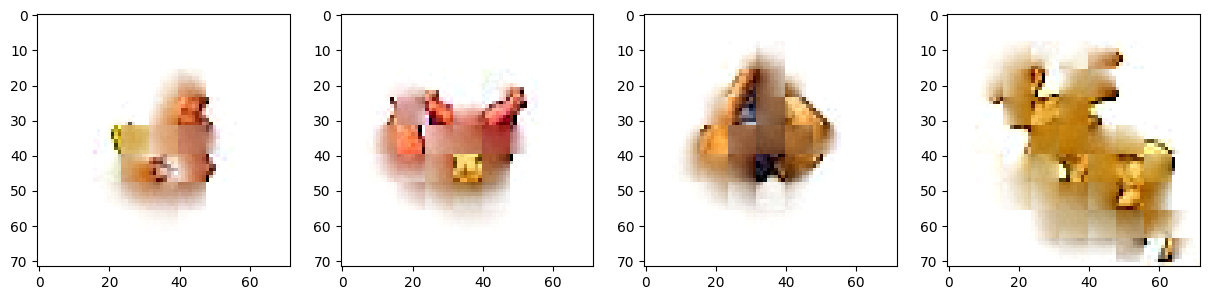

 33%|███▎      | 82000/250000 [13:48<27:25, 102.09it/s]

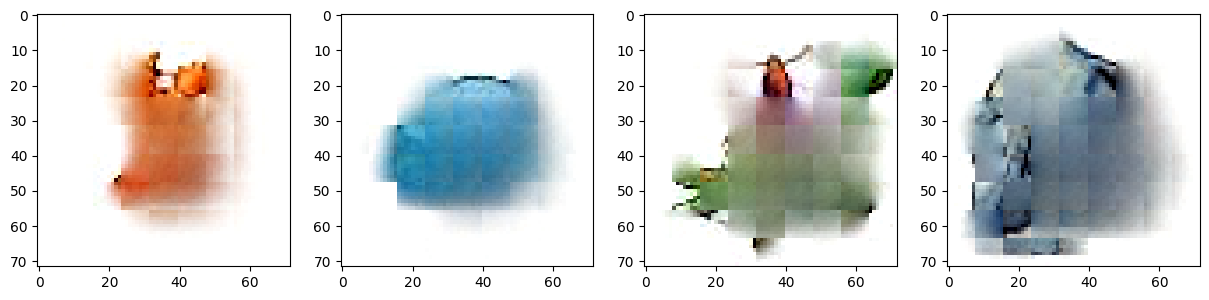

 34%|███▎      | 83995/250000 [14:08<27:24, 100.96it/s]

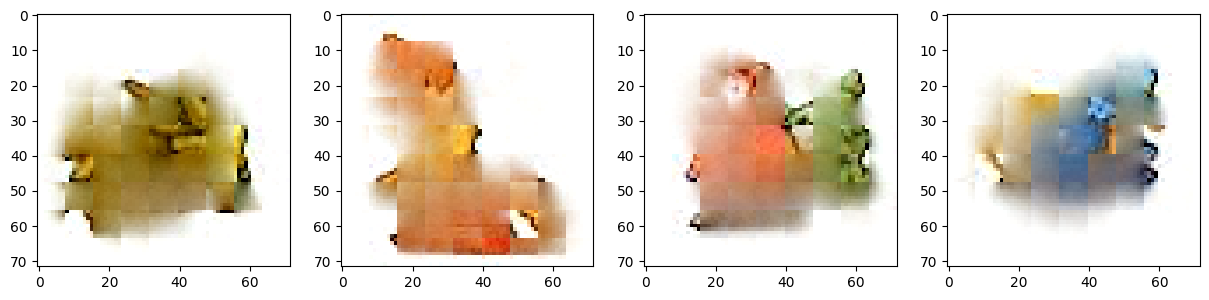

 34%|███▍      | 85992/250000 [14:28<27:30, 99.35it/s] 

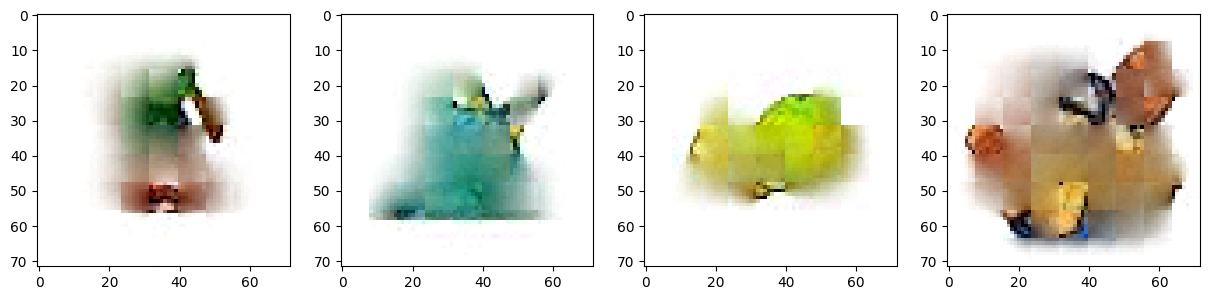

 35%|███▌      | 88000/250000 [14:49<27:33, 97.97it/s] 

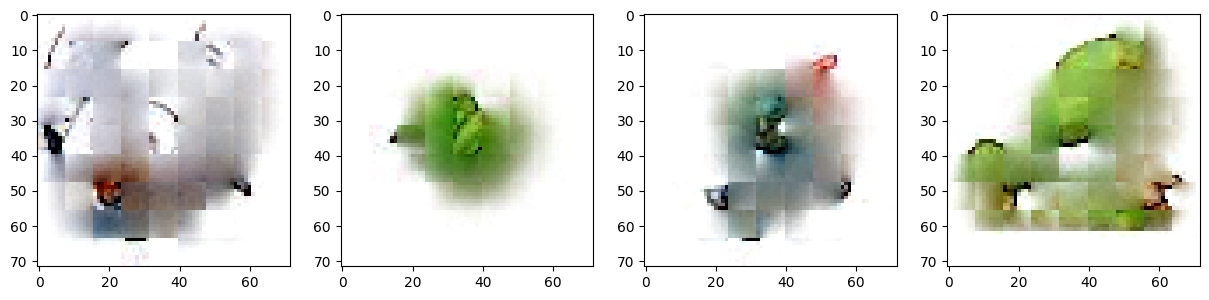

 36%|███▌      | 90000/250000 [15:09<27:21, 97.49it/s] 

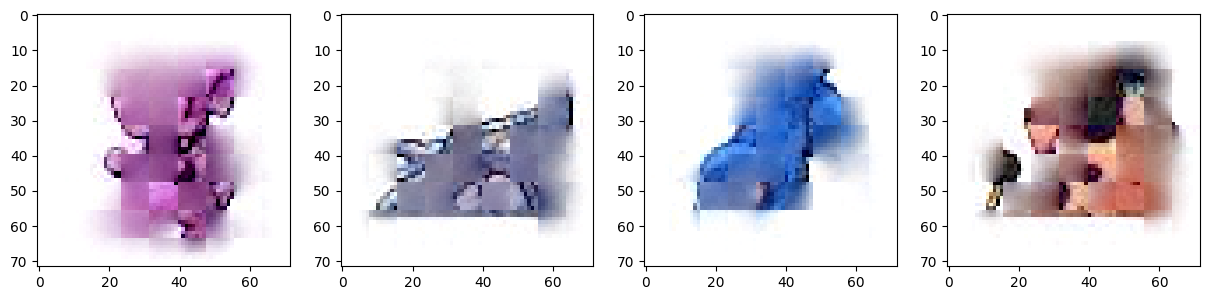

 37%|███▋      | 91998/250000 [15:29<25:38, 102.71it/s]

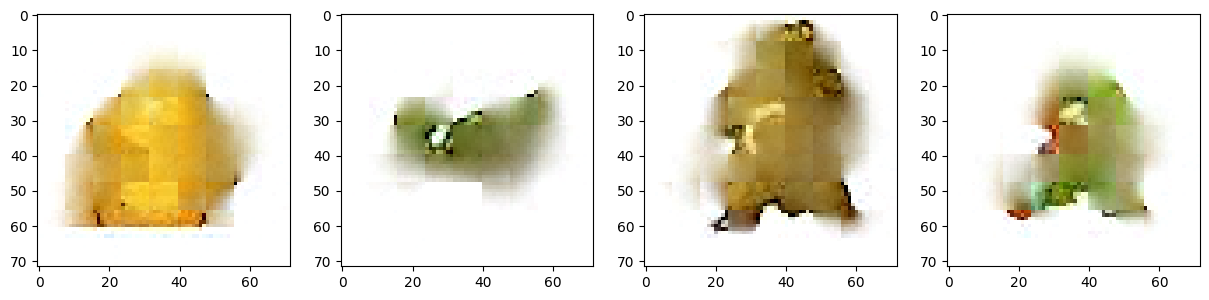

 38%|███▊      | 93996/250000 [15:49<25:47, 100.80it/s]

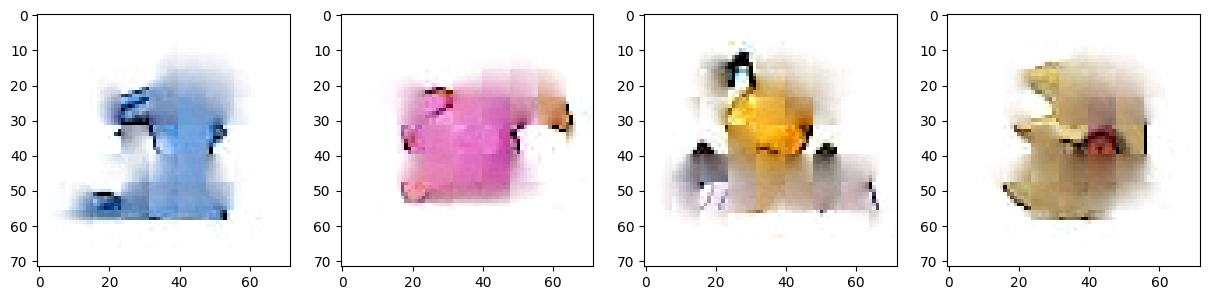

 38%|███▊      | 95999/250000 [16:10<25:43, 99.77it/s] 

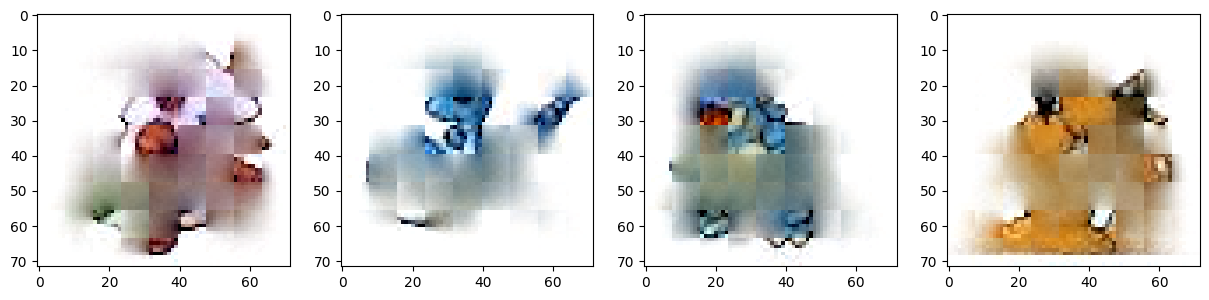

 39%|███▉      | 97996/250000 [16:30<25:08, 100.77it/s]

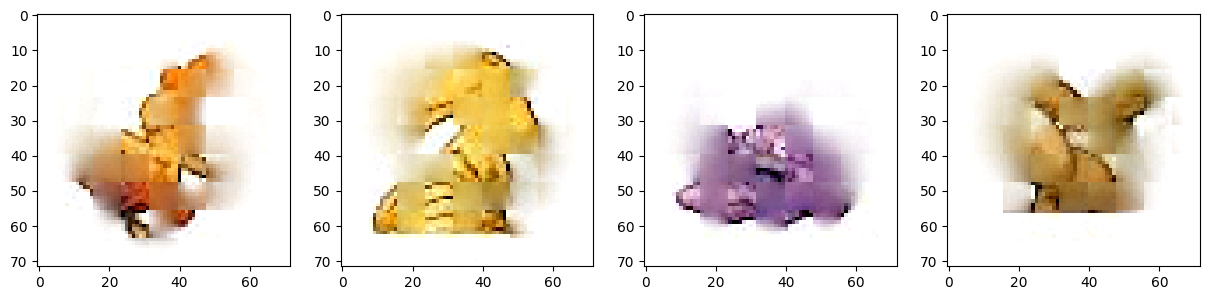

 40%|████      | 100000/250000 [16:50<24:31, 101.91it/s]

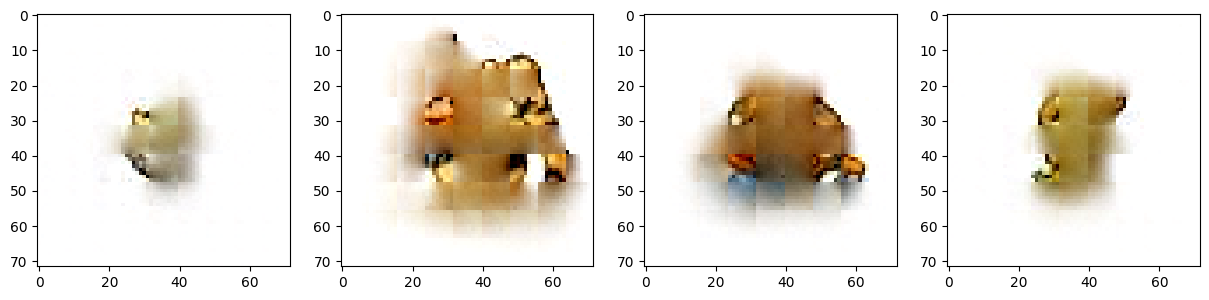

 41%|████      | 101992/250000 [17:10<24:34, 100.36it/s]

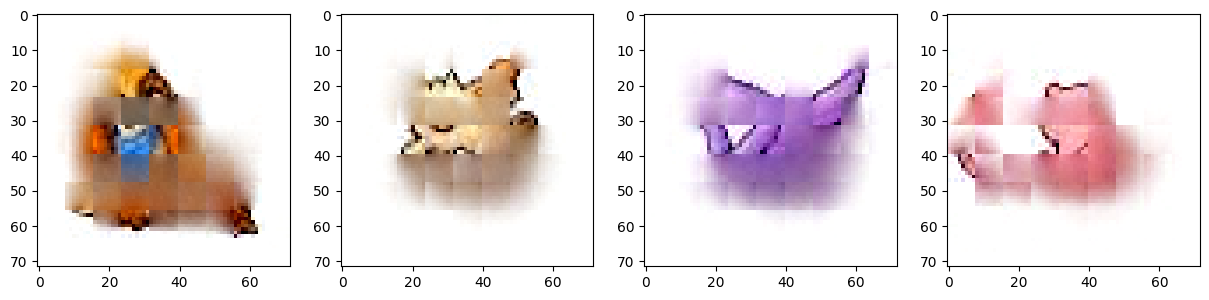

 42%|████▏     | 103998/250000 [17:31<24:08, 100.81it/s]

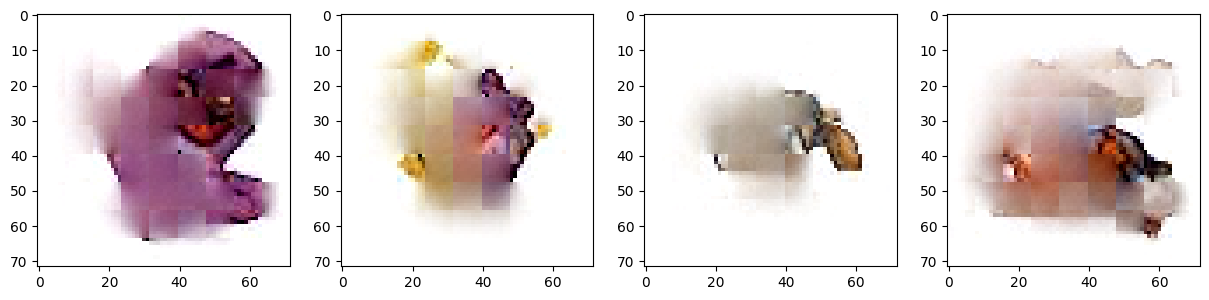

 42%|████▏     | 105991/250000 [17:51<24:24, 98.35it/s] 

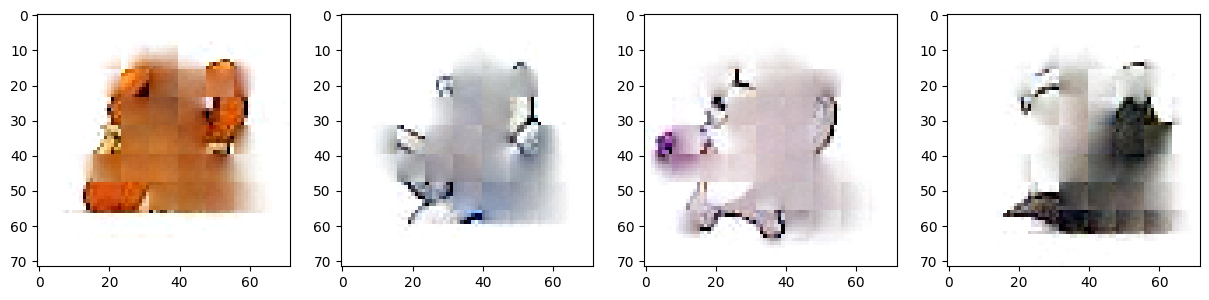

 43%|████▎     | 107999/250000 [18:11<24:08, 98.05it/s] 

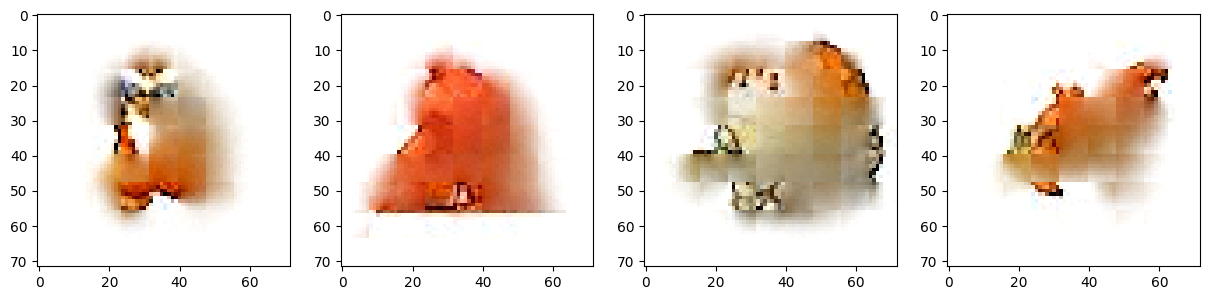

 44%|████▍     | 110000/250000 [18:31<24:08, 96.63it/s] 

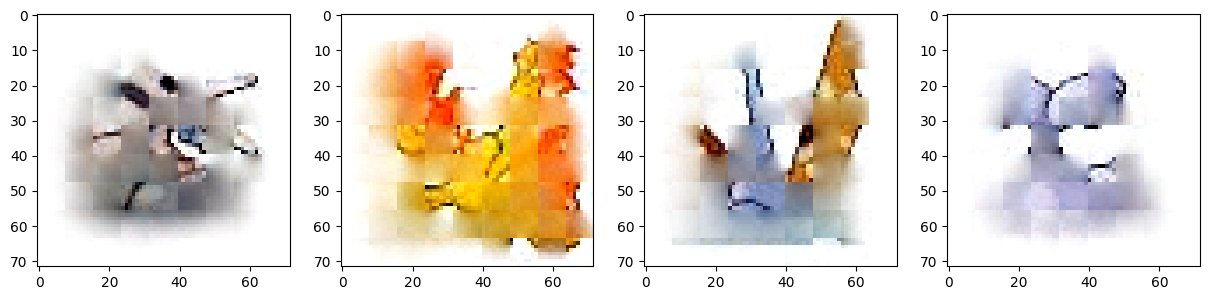

 45%|████▍     | 111993/250000 [18:52<23:19, 98.64it/s] 

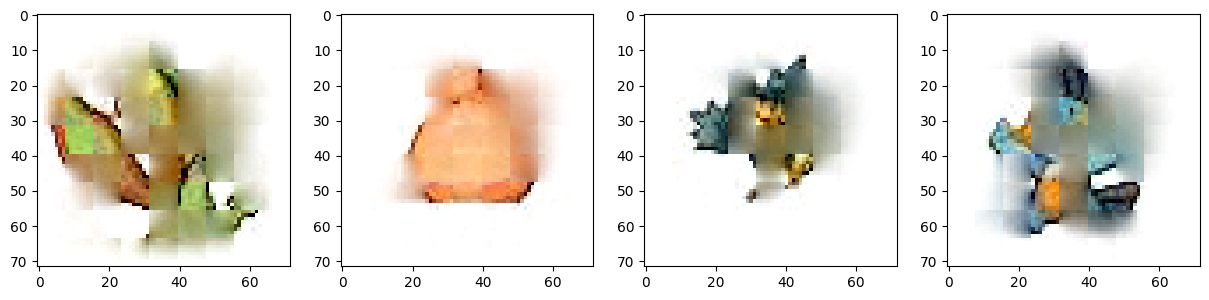

 46%|████▌     | 113999/250000 [19:12<22:27, 100.92it/s]

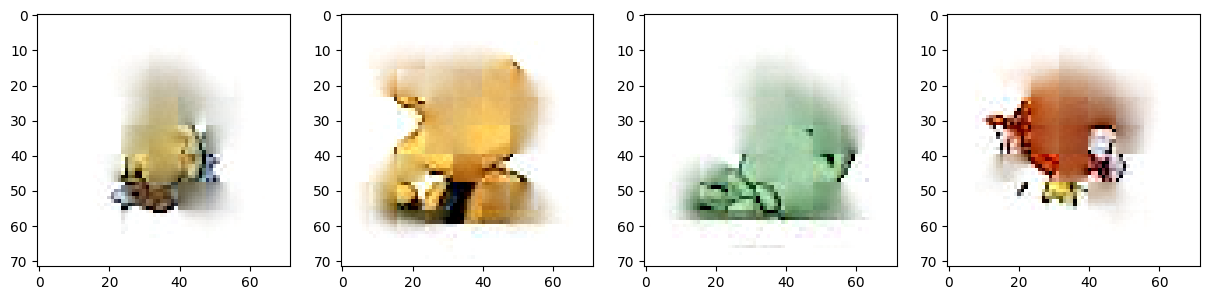

 46%|████▋     | 116000/250000 [19:32<22:24, 99.65it/s] 

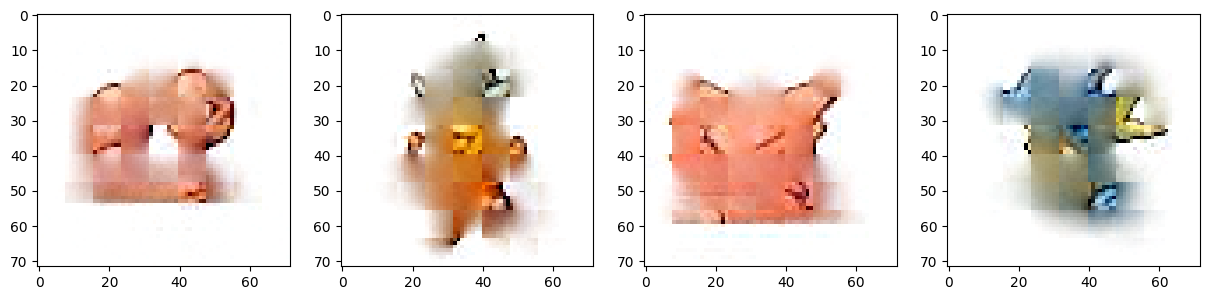

 47%|████▋     | 117998/250000 [19:52<21:38, 101.62it/s]

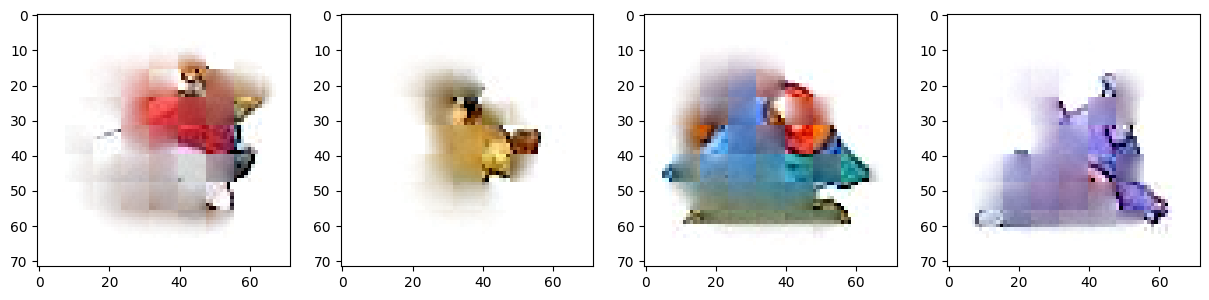

 48%|████▊     | 119999/250000 [20:12<21:31, 100.69it/s]

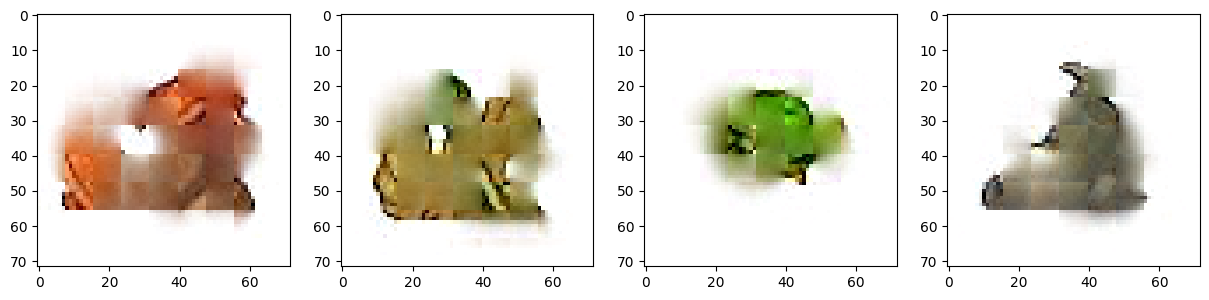

 49%|████▉     | 121995/250000 [20:33<21:50, 97.70it/s] 

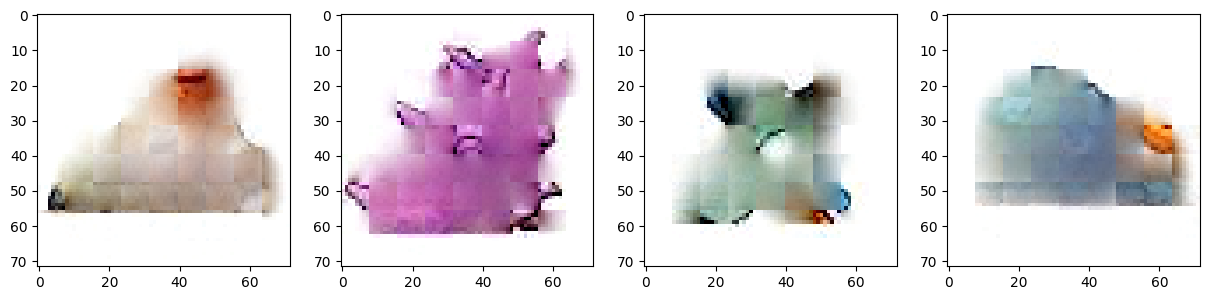

 50%|████▉     | 123992/250000 [20:53<21:53, 95.92it/s] 

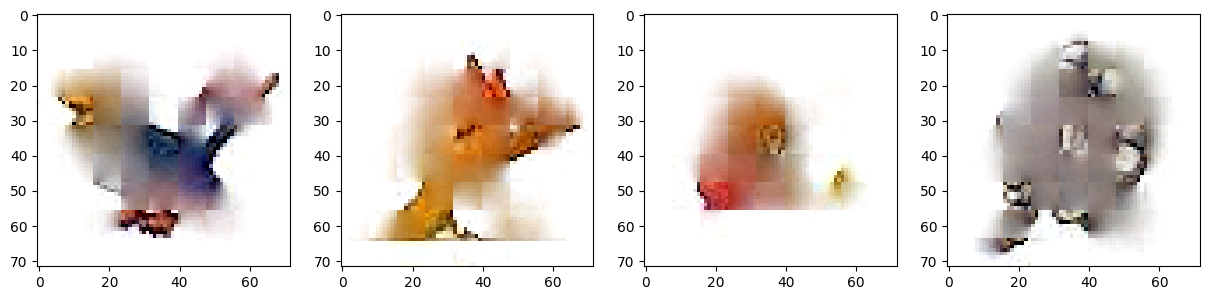

 50%|█████     | 125997/250000 [21:13<21:31, 95.99it/s] 

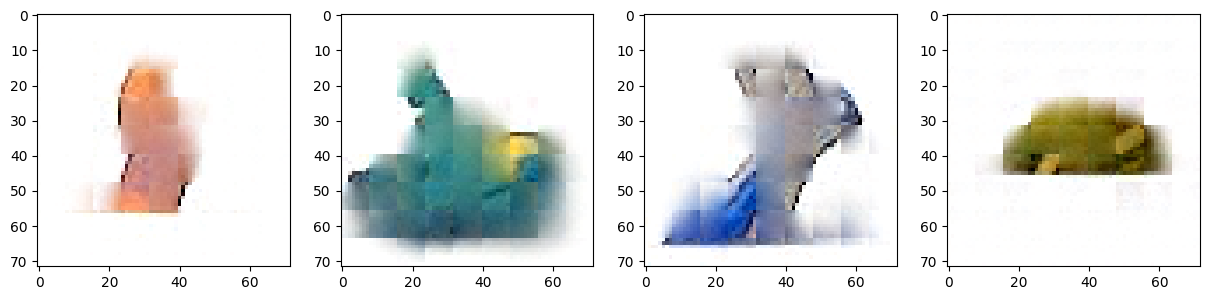

 51%|█████     | 127996/250000 [21:33<20:34, 98.79it/s] 

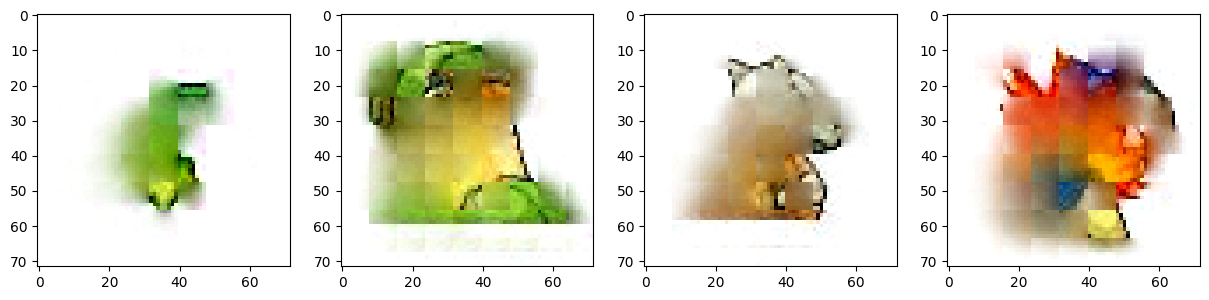

 52%|█████▏    | 129996/250000 [21:54<19:24, 103.07it/s]

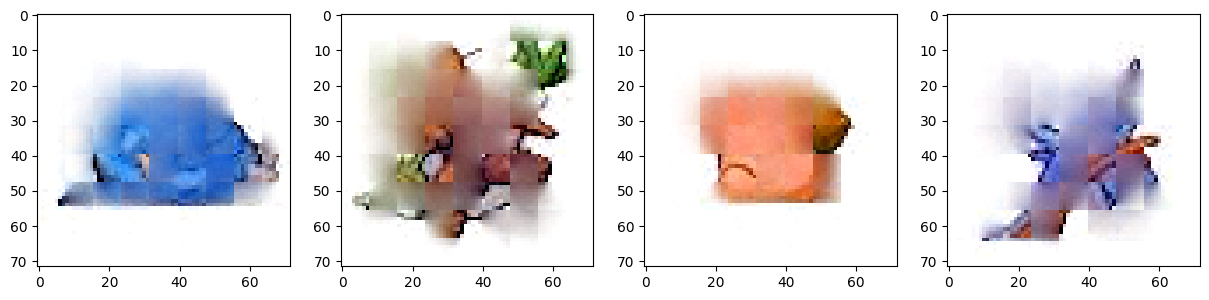

 53%|█████▎    | 131998/250000 [22:14<19:14, 102.24it/s]

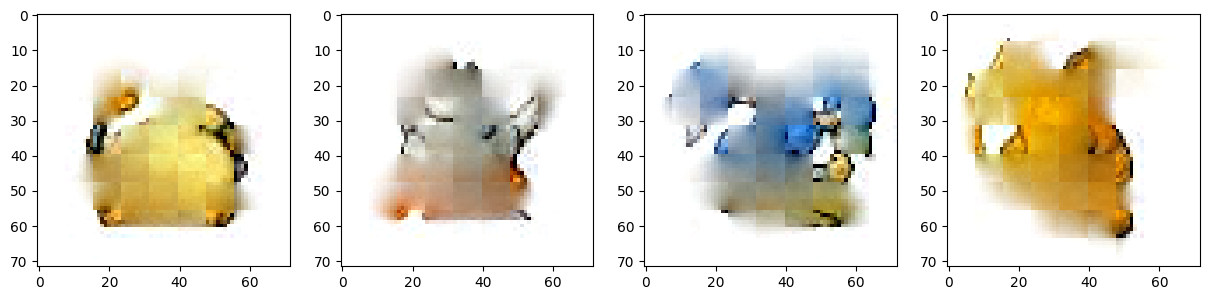

 54%|█████▎    | 133994/250000 [22:34<19:02, 101.57it/s]

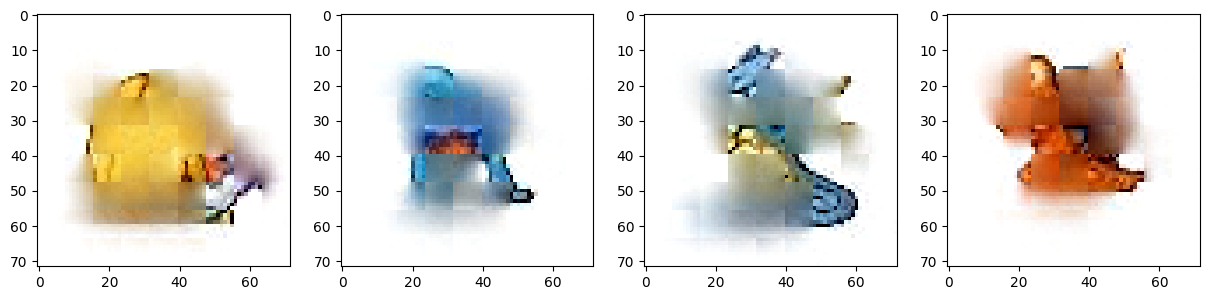

 54%|█████▍    | 135993/250000 [22:54<19:05, 99.50it/s] 

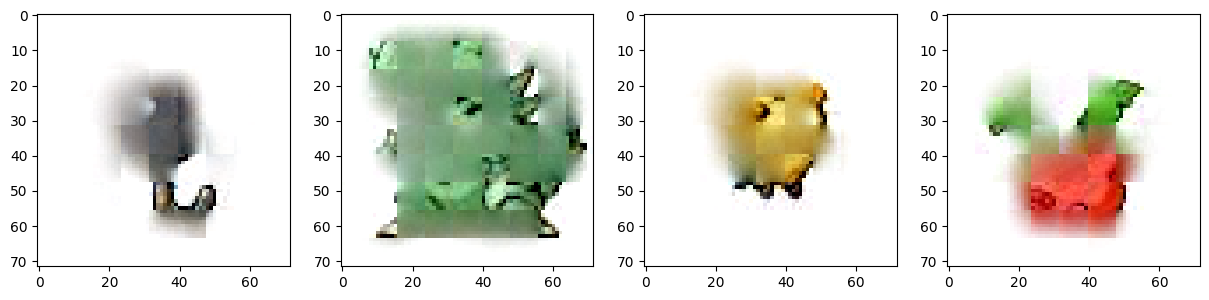

 55%|█████▌    | 137993/250000 [23:15<18:50, 99.06it/s] 

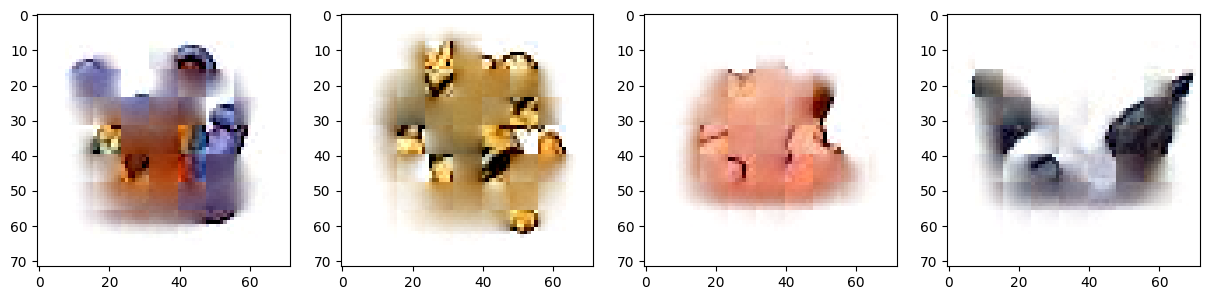

 56%|█████▌    | 139998/250000 [23:35<18:19, 100.08it/s]

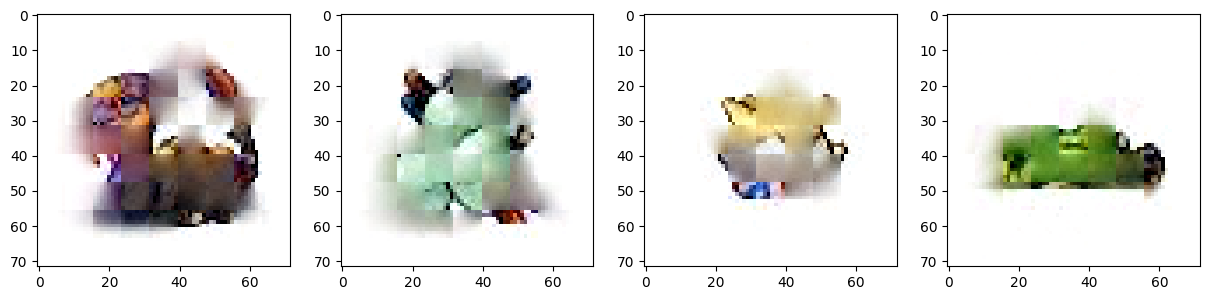

 57%|█████▋    | 141990/250000 [23:55<17:48, 101.10it/s]

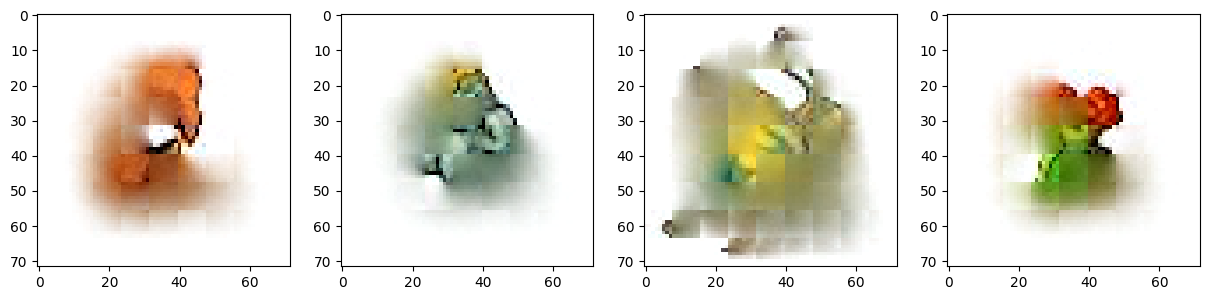

 58%|█████▊    | 143997/250000 [24:15<17:44, 99.57it/s] 

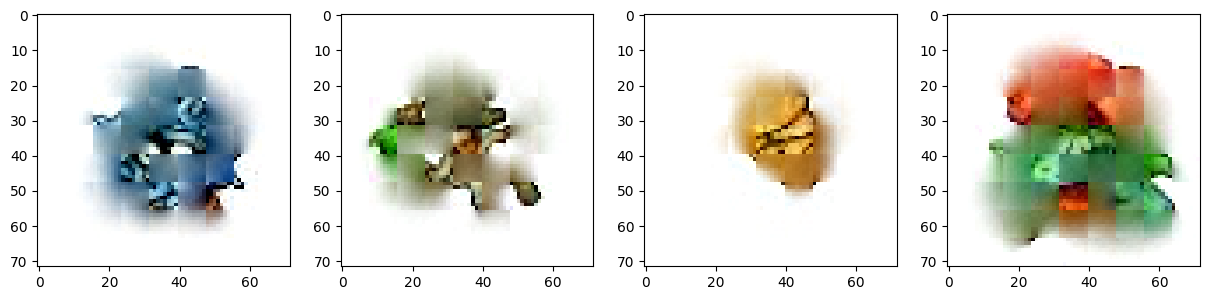

 58%|█████▊    | 145991/250000 [24:36<17:11, 100.81it/s]

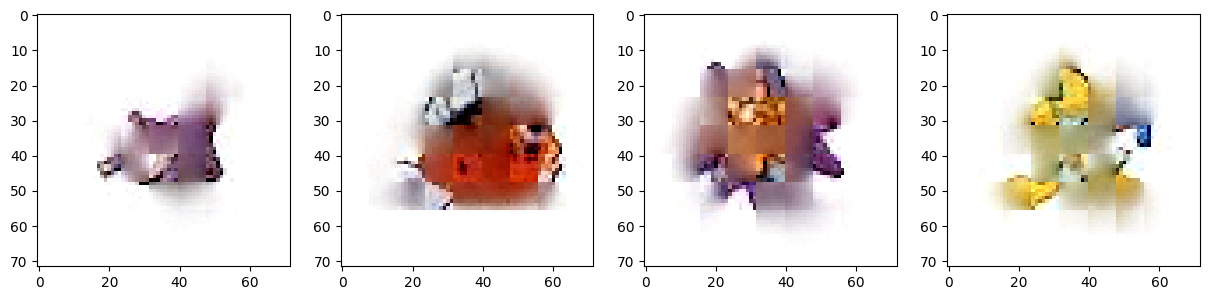

 59%|█████▊    | 146857/250000 [24:45<17:22, 98.89it/s] 


KeyboardInterrupt: 

In [6]:
model = MyMAE(72, 8, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
mse_loss = nn.MSELoss()

def train():

    for i in tqdm(range(250000), miniters=10):
        bs = 16
        source = torch.randint(0, 5, (bs,))
        batch = torch.randperm(385)[:bs]
        x0 = pimages[source, batch]
        x0 = torch.stack([pos_transform(x) for x in x0], dim=0)

        optimizer.zero_grad()

        reconstruction = model(x0)
        loss = mse_loss(reconstruction, x0) + 1.0 * ssim_loss(reconstruction, x0).mean()

        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            fig, axes = plt.subplots(1, 4, figsize=(15, 15))
            plot_image(reconstruction[0], axes[0])
            plot_image(reconstruction[1], axes[1])
            plot_image(reconstruction[2], axes[2])
            plot_image(reconstruction[3], axes[3])
            plt.show()

model.train()
train()
